## Event Analysis Notebook

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS
from tabulate import tabulate
import analysis_functions

In [2]:
### Load Data 
voteData = pd.read_csv(r'C:\Users\beneb\Desktop\plural_data\votes.csv')
groupData = pd.read_csv(r'C:\Users\beneb\Desktop\plural_data\users_to_groups.csv')
forumQuestions = pd.read_csv(r'C:\Users\beneb\Desktop\plural_data\forum_questions.csv')
groupCategories = pd.read_csv(r'C:\Users\beneb\Desktop\plural_data\group_categories.csv')
questionOptions = pd.read_csv(r'C:\Users\beneb\Desktop\plural_data\question_options.csv')

# print("voteData:", len(voteData))
# print("groupData:", len(groupData))
# print("forumQuestions:", len(forumQuestions))
# print("groupCategories:", len(groupCategories))

### Manual Analysis

In [3]:
# Specify group categories to be considered for the analysis (at least 'affiliation' must be specified)
group_categories = ['affiliation', 'private']

# Specify an option id
option_id = '4ad65252-e651-460c-af6b-289769a3964b'

In [4]:
# Analysis of a given option id 
votes = analysis_functions.get_latest_vote_by_user_and_optionid(voteData, option_id)
filtered_votes = analysis_functions.filter_zero_votes(votes)
group_categories_ids = analysis_functions.get_group_categories_ids(groupCategories, group_categories)
groups = analysis_functions.get_groups_by_user_and_optionid(groupData, filtered_votes, group_categories_ids)
memberships = analysis_functions.create_group_memberships(groups)
filtered_groups = analysis_functions.remove_duplicate_groups(groups)
plurality_score = analysis_functions.connection_oriented_cluster_match(filtered_groups, filtered_votes)

# print("votes:", votes)
# print("filtered_votes:", filtered_votes)
# print("group_categories_ids:", group_categories_ids)
# print("groups:", groups)
# print("memberships:", memberships)
# print("filtered_groups:", filtered_groups)
# print("plurality_score:", plurality_score)

### Voting Results Table  

In [5]:
# specify a question id 
question_id = '5eaea820-8b02-446c-bf17-59f6fc1799bc'

# Specify group categories to be considered for the analysis (at least 'affiliation' must be specified)
group_categories = ['affiliation', 'private']

# get list of option ids related to the question id 
optionIds = questionOptions[questionOptions['question_id'] == question_id]['id'].tolist()

In [6]:
# Generate Results 
results_dict = analysis_functions.get_results_dict(optionIds, voteData, groupData, groupCategories, group_categories)

# add a rank to each result category (plural score, raw votes, quadratic score)
results_dict_with_ranks = analysis_functions.calculate_ranks(results_dict)

# Sort results according to the plurality score
sorted_results_dict_with_ranks = dict(sorted(results_dict_with_ranks.items(), key=lambda item: item[1]['pluralityScore']['score'], reverse=True))

In [7]:
# Create data table 
table_data = []
headers = ['Options', 'Plurality Score', 'Quadratic Score', 'Raw Votes']

option_counter = 1

for option, data in sorted_results_dict_with_ranks.items():
    row = [f'Option {option_counter}']
    for category in ['pluralityScore', 'quadraticScore', 'totalRawVotes']:
        row.append(round(data[category]['score'], 3))
    table_data.append(row)
    option_counter += 1 

df = pd.DataFrame(table_data, columns=headers)

In [8]:
# Save and Print results 
df.to_excel('plots-and-tables/voting_results.xlsx', index=False)
print(tabulate(df, headers='keys', tablefmt='pretty'))

+----+-----------+-----------------+-----------------+-----------+
|    |  Options  | Plurality Score | Quadratic Score | Raw Votes |
+----+-----------+-----------------+-----------------+-----------+
| 0  | Option 1  |      59.45      |     64.658      |    213    |
| 1  | Option 2  |     42.394      |     43.858      |    196    |
| 2  | Option 3  |     39.655      |     50.425      |    263    |
| 3  | Option 4  |     38.545      |     41.391      |    124    |
| 4  | Option 5  |     36.083      |     37.335      |    124    |
| 5  | Option 6  |     36.031      |     37.566      |    110    |
| 6  | Option 7  |     32.766      |     31.035      |    82     |
| 7  | Option 8  |      30.99      |     32.565      |    86     |
| 8  | Option 9  |     27.541      |     28.423      |    60     |
| 9  | Option 10 |     27.254      |     28.397      |    82     |
| 10 | Option 11 |     25.808      |     25.104      |    64     |
| 11 | Option 12 |     25.604      |      26.75      |    67  

### Result Visualizations

#### Ranking Distribution

In [9]:
# Define the categories and custom labels for the x-axis
categories = ['pluralityScore', 'quadraticScore', 'totalRawVotes']
custom_labels = ['Plurality Score Rank', 'Quadratic Score Rank', 'Raw Votes Rank']

# Get the number of options
num_options = len(sorted_results_dict_with_ranks)

# Get a list of distinct colors
colors = list(TABLEAU_COLORS.values())

# Ensure enough colors for all options, if not, repeat the colors
while len(colors) < num_options:
    colors.extend(colors)

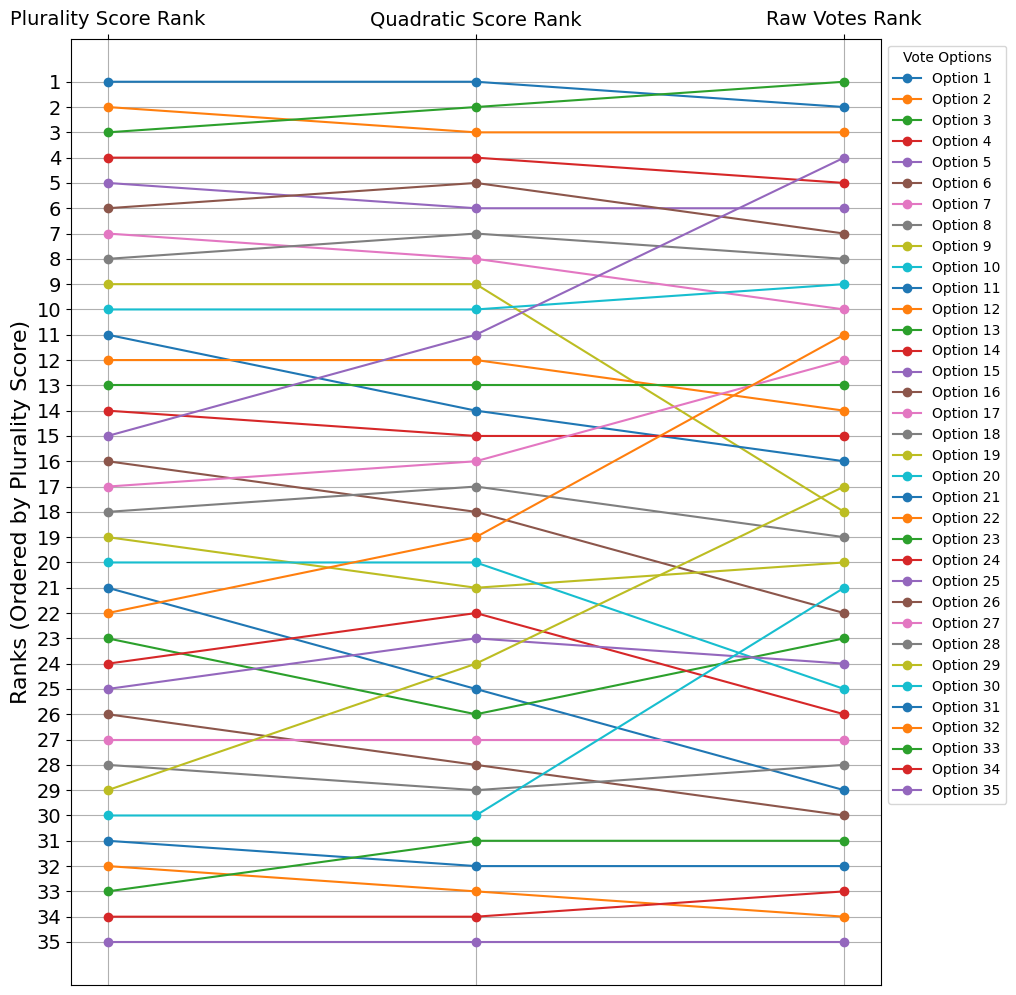

In [10]:
# Bump Chart 
plt.figure(figsize=(10, 10))

for i, (option, option_data) in enumerate(sorted_results_dict_with_ranks.items()):
    ranks = [option_data[category]['rank'] for category in categories]
    plt.plot(categories, ranks, marker='o', label=f'Option {i+1}', color=colors[i])

plt.gca().invert_yaxis() 
plt.yticks(range(1, max(ranks) + 1))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Vote Options')
plt.grid(True)
plt.gca().xaxis.tick_top()
plt.gca().set_xticks(range(len(categories)))
plt.gca().set_xticklabels(custom_labels)
plt.tight_layout()
plt.gca().tick_params(axis='y', labelsize=14)
plt.gca().tick_params(axis='x', labelsize=14)
plt.xlabel('', fontsize=16)
plt.ylabel('Ranks (Ordered by Plurality Score)', fontsize=16)
plt.title('', fontsize=16)

# Save the plot as a PNG file
plt.savefig('plots-and-tables/bump_chart.png')

#### Highlighted Ranking Distribution

In [11]:
# Calculate the absolute difference in ranks for each ranking category
rank_diff = {}
for option, option_data in sorted_results_dict_with_ranks.items():
    ranks = [option_data[category]['rank'] for category in categories]
    diff = max(ranks) - min(ranks)
    rank_diff[option] = diff

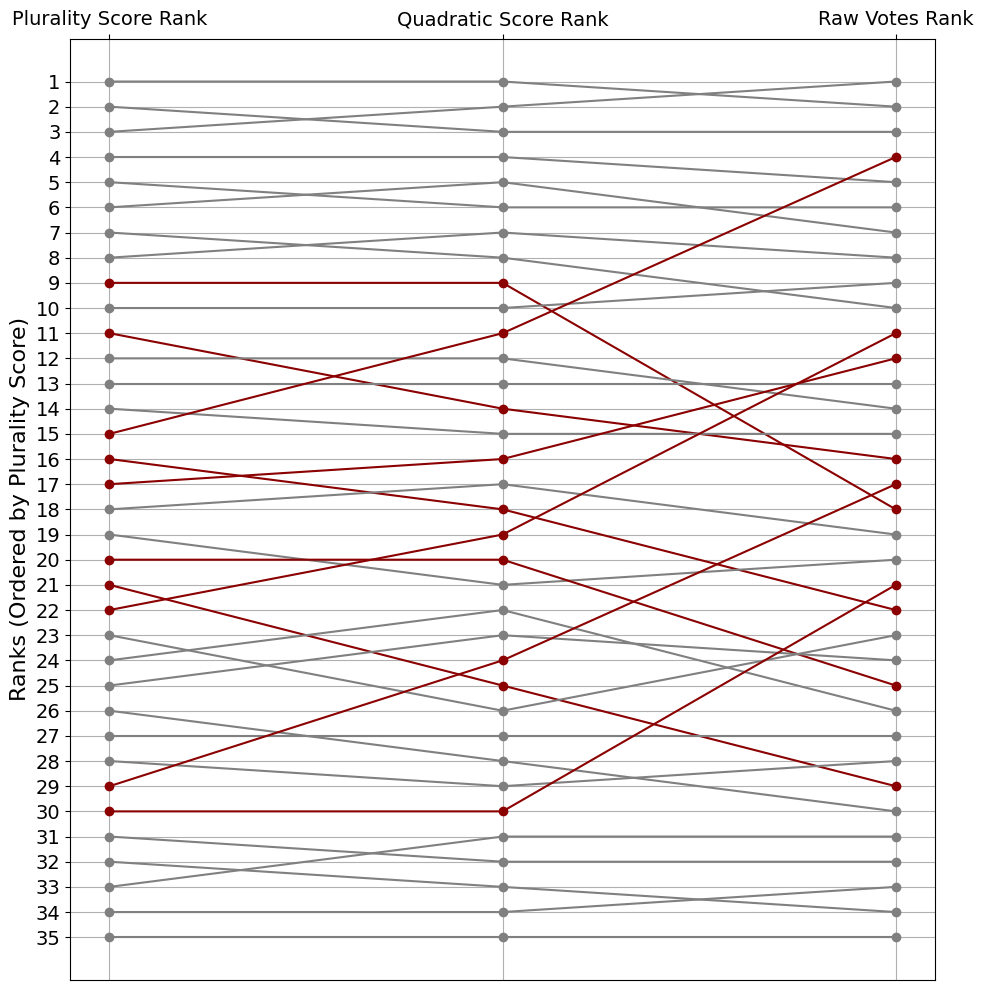

In [12]:
# Bump chart highlighting large differences in the ranking distribution
plt.figure(figsize=(10, 10))

for i, (option, option_data) in enumerate(sorted_results_dict_with_ranks.items()):
    ranks = [option_data[category]['rank'] for category in categories]
    if rank_diff[option] > 4:
        color = 'darkred'
    else:
        color = 'gray'
    plt.plot(categories, ranks, marker='o', label=f'Option {i+1}', color=color)

plt.gca().invert_yaxis()
plt.yticks(range(1, max(ranks) + 1))
plt.gca().tick_params(axis='y', labelsize=14)
plt.gca().tick_params(axis='x', labelsize=14)
plt.xlabel('', fontsize=16)
plt.ylabel('Ranks (Ordered by Plurality Score)', fontsize=16)
plt.title('', fontsize=16)
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Vote Options')  # Include legend title
plt.grid(True)
plt.gca().xaxis.tick_top()
plt.gca().set_xticks(range(len(categories)))
plt.gca().set_xticklabels(custom_labels, fontsize=14)
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('plots-and-tables/bump_chart_without_legend.png')

### Network Visualization

In [28]:
import networkx as nx
num_unique_user_ids = groupData['user_id'].nunique()

print("Number of unique user IDs:", num_unique_user_ids)

Number of unique user IDs: 75


In [30]:
distinct_user_ids = voteData['user_id'].unique().tolist()
print(len(distinct_user_ids))

36


In [31]:
filtered_groupData = groupData[groupData['user_id'].isin(distinct_user_ids)]
num_unique_user_ids = filtered_groupData['user_id'].nunique()

print("Number of unique user IDs:", num_unique_user_ids)


Number of unique user IDs: 36


In [38]:
# Create a DataFrame from filtered_groupData
df = pd.DataFrame(filtered_groupData)

# Group DataFrame by group_id
grouped = df.groupby('group_id')

# Initialize an empty list to store edges
edge_list = []

# Iterate over groups
for group_id, group_data in grouped:
    # Create pairs of users within the group
    for i in range(len(group_data)):
        for j in range(i + 1, len(group_data)):
            edge_list.append({'source': group_data.iloc[i]['user_id'], 'target': group_data.iloc[j]['user_id']})

# Convert the edge list to a DataFrame
edge_df = pd.DataFrame(edge_list)

# Create a set of all unique user IDs
all_user_ids = set(df['user_id'])

# Create a node list containing all user IDs
node_list = [{'id': user_id} for user_id in all_user_ids]

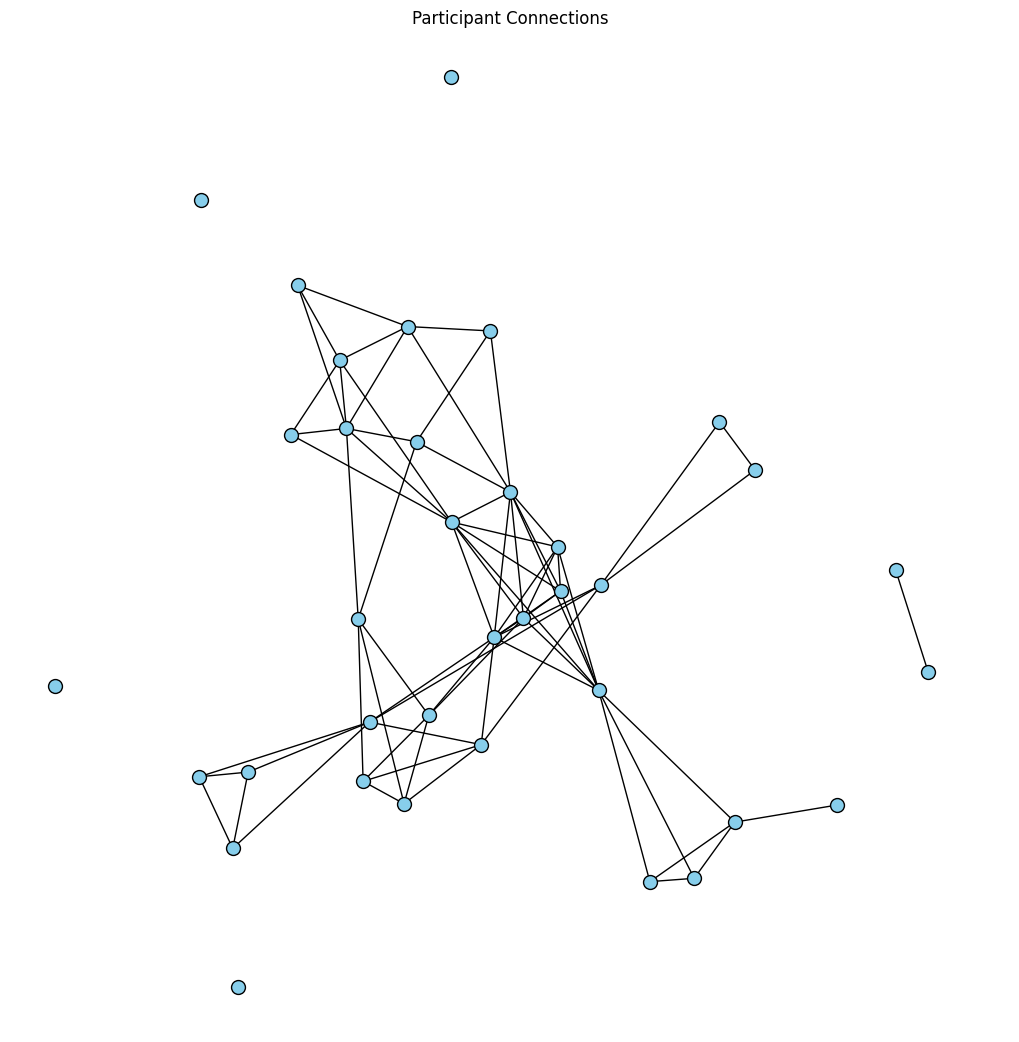

In [48]:
 
# Plot the graph
plt.figure(figsize=(10, 10))
G = nx.Graph()

# Add nodes from node list
G.add_nodes_from([node['id'] for node in node_list])

# Add edges from edge list
G.add_edges_from([(row['source'], row['target']) for _, row in edge_df.iterrows()])

pos = nx.spring_layout(G, k=0.8, iterations=100, scale=2.0)
nx.draw(G, pos, with_labels=False, node_size=100, node_color='skyblue', edgecolors='black', font_size=8)
plt.title('Participant Connections')
plt.savefig('plots-and-tables/participant_connections_plot.png')